# Анализ отзывов на банки

В данных представлены отзывы на банки с сайта [banki.ru](https://www.banki.ru/)
- body - сам отзыв
- title - название отзыва
- rating - оценка по отзыву, варьируется от 1 до 5
- bank_name - название банка
- date - дата публикации отзыва

Необходимо EDA (Exploratory Data Analysis) по этим данным и сделать несколько выводов (приветствуются визуализации):
- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов
- нет ли в данных в целом каких-то странностей на ваш взгляд?
- дополнительный EDA на ваше усмотрение, возможные интересные наблюдения

Необходимо выбрать метрику и построить бинарный классификатор отзывов, добившись при этом лучшей метрики на валидационной выборке (отзывы >=3 считать положительными, <3 - отрицательными)

Будет плюсом визуализация результатов работы модели (ответ на вопрос: почему построенная модель считает этот отзыв положительным или отрицательным?)

Для решения задачи было использовано два алгоритма -- логистическая регрессия и градиентный бустинг. Для оценки качества моделей была выбрана метрика F1. Для обеих моделей она равна 0.97

In [1]:
# Импортируем pandas
import pandas as pd
import numpy as np

In [2]:
# Кладем в переменную путь к данным относительно этого ноутбука 
import os
fpath = os.path.join('data', 'data.csv.gz')
fpath

'data\\data.csv.gz'

In [3]:
# Читаем данные из таблицы в архиве в датафрейм
import gzip
with gzip.open(fpath, 'r') as f_in:
    df = pd.read_csv(f_in)
df.head()

,body,title,rating,bank_name,date
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36


In [4]:
# Импортируем библиотеки для визуализации и настраиваем тему
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")
sns.set_color_codes("muted")

In [5]:
# Проверяем, везде ли есть данные
df.describe(include='all')

,body,title,rating,bank_name,date
count,92735,92735,92735.000000,92735,92735
unique,91832,54505,NaN,157,91059
top,&lt;p&gt;Что мне больше всего нравится в банке...,Благодарность,NaN,Тинькофф Банк,2022-10-28 15:57:44
freq,33,2051,NaN,44864,4
mean,NaN,NaN,4.064086,NaN,NaN
std,NaN,NaN,1.620702,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN
25%,NaN,NaN,4.000000,NaN,NaN
50%,NaN,NaN,5.000000,NaN,NaN
75%,NaN,NaN,5.000000,NaN,NaN


## Data Cleaning

In [6]:
import html
df['body_cleaned'] = df['body'].str.lower() # Приводим все слова к нижнему регистру
df['body_cleaned'] = df['body'].apply(html.unescape) # Расшифровываем html-теги
df['body_cleaned'].replace('</?p>','',regex=True, inplace=True) # И убираем их
df['body_cleaned'].replace('[^\S ]+',' ',regex=True, inplace=True) # Убираем переносы строки и табуляцию
df['body_cleaned']

0        Добрый день пишу сюда для более скорого разреш...
1        При возврате просроченной задолженности, банк ...
2        07.09.22 ю была оформлена кредитная карта "120...
3        Новый год начинается с приятностей) Никогда не...
4        Увидела на сайте Газпромбанка акцию с бонусом ...
                               ...                        
92730    30 августа обнаружила, что баланс уменьшился. ...
92731    Обратился с вопросом (6908609) по All Airlines...
92732    В августе 2021 я досрочно погасил ипотеку (кре...
92733    9.08.22 оформлен кредит на покупку автомобиля ...
92734    Хочется выразить благодарность всему коллектив...
Name: body_cleaned, Length: 92735, dtype: object

In [7]:
# Добавляем столбец, в котором указывается класс отзыва: 1 -- положительный, 0 -- отрицательный

df['target'] = (df['rating']>=3).replace({True: 1, False: 0})
df['target'].value_counts()

1    71892
0    20843
Name: target, dtype: int64

In [8]:
df.head()

,body,title,rating,bank_name,date,body_cleaned,target
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11,Добрый день пишу сюда для более скорого разреш...,0
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46,"При возврате просроченной задолженности, банк ...",0
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11,"07.09.22 ю была оформлена кредитная карта ""120...",0
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07,Новый год начинается с приятностей) Никогда не...,1
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36,Увидела на сайте Газпромбанка акцию с бонусом ...,0


In [9]:
# Готовим список лишних слов и символов
# К таким относятся почти все знаки препинания, стоп-слова и отдельные латинские буквы

import nltk
from nltk.corpus import stopwords
from string import punctuation, ascii_lowercase
nltk.download("stopwords", quiet=True)

allowed_punct = list('()!')

to_remove = stopwords.words("russian") + \
    list(filter(lambda ch: ch not in allowed_punct, list(punctuation))) + \
    list('«»—') + \
    list(ascii_lowercase) 
print(to_remove)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [11]:
# Лемматизируем отзывы и заголовки к ним

from pymorphy2 import MorphAnalyzer
from nltk import tokenize

pymorphy2_analyzer = MorphAnalyzer()

def make_bow(s):
    tokenized = tokenize.TweetTokenizer().tokenize(s)
    lemmatized = []
    for t in tokenized:
        if t not in to_remove:
            if t.isalpha():
                lemmatized.append(pymorphy2_analyzer.normal_forms(t)[0])
            else:
                lemmatized.append(t)
    return ' '.join(lemmatized)

# %timeit
df['bow_title'] = df['title'].apply(make_bow)
df['bow_body'] = df['body_cleaned'].apply(make_bow)
df

In [ ]:
# !pip install fastparquet

In [12]:
# Сохраняем датафрейм для работы в будущем, чтобы не пришлось лемматизировать отзывы заново

# filename = 'lemmatized_2024-01-22.parquet.gzip'
# df.to_parquet(filename, compression='gzip', index=False)
# df = pd.read_parquet(filename)

In [13]:
# Соединяем лемматизированные заголовки и отзывы
df['full_text'] = df['bow_title'] + ' ' + df['bow_body']
df

,body,title,rating,bank_name,date,body_cleaned,target,bow_title,bow_body,full_text
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11,Добрый день пишу сюда для более скорого разреш...,0,заблокировать средство,добрый день писать сюда скорый разрешение вопр...,заблокировать средство добрый день писать сюда...
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46,"При возврате просроченной задолженности, банк ...",0,возврат просрочить задолженномть,при возврат просрочить задолженность банк звон...,возврат просрочить задолженномть при возврат п...
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11,"07.09.22 ю была оформлена кредитная карта ""120...",0,ошибочный начисление комиссия затягивание процесс,07.09 22 ю оформить кредитный карта 120 день в...,ошибочный начисление комиссия затягивание проц...
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07,Новый год начинается с приятностей) Никогда не...,1,клиентоориентиванность 10 10,новый год начинаться приятность ) никогда пони...,клиентоориентиванность 10 10 новый год начинат...
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36,Увидела на сайте Газпромбанка акцию с бонусом ...,0,как газпромбанк обманывать клиент акционный карта,увидеть сайт газпромбанк акция бонус кредитный...,как газпромбанк обманывать клиент акционный ка...
...,...,...,...,...,...,...,...,...,...,...
92730,"30 августа обнаружила, что баланс уменьшился. ...",Банк списал деньги и теперь рекомендует их сам...,1,Совкомбанк,2022-09-02 11:47:44,"30 августа обнаружила, что баланс уменьшился. ...",0,банк списать деньга рекомендовать самостоятель...,30 август обнаружить баланс уменьшиться в исто...,банк списать деньга рекомендовать самостоятель...
92731,Обратился с вопросом (6908609) по All Airlines...,Отличная консультация от сотрудника поддержки,5,Тинькофф Банк,2022-09-02 11:46:24,Обратился с вопросом (6908609) по All Airlines...,1,отличный консультация сотрудник поддержка,обратиться вопрос ( 6908609 ) all airlines зак...,отличный консультация сотрудник поддержка обра...
92732,В августе 2021 я досрочно погасил ипотеку (кре...,Снятие обременения с квартиры,2,Россельхозбанк,2022-09-02 11:34:34,В августе 2021 я досрочно погасил ипотеку (кре...,0,снятие обременение квартира,в август 2021 досрочно погасить ипотека ( кред...,снятие обременение квартира в август 2021 доср...
92733,9.08.22 оформлен кредит на покупку автомобиля ...,Штрафные санкции,1,Драйв Клик Банк,2022-09-02 11:28:32,9.08.22 оформлен кредит на покупку автомобиля ...,0,штрафной санкция,9.08 22 оформить кредит покупка автомобиль сал...,штрафной санкция 9.08 22 оформить кредит покуп...


In [14]:
# df['body_len'] = np.log(df['body_cleaned'].str.len().fillna(0))

## Logistic Regression

In [15]:
# Делим данные на инпут и таргет
X = df['full_text']
y = df['target']

In [16]:
# Делим датасет на обучающую и тестовую выборки. 
# На вход будут подаваться только лемматизированные заголовки+отзывы

SEED = 42
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

In [17]:
X_train.shape, X_test.shape

((69551,), (23184,))

In [18]:
# Векторизируем текст с помощью TfidfVectorizer
# И обучаем логистическую регрессию

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import GridSearchCV

vectorizer = TfidfVectorizer(ngram_range=(1, 1)) # Векторизируем с помощью tf/idf

scaler = MaxAbsScaler()

# Векторизируем и масштабируем обучающие данные
matrix = vectorizer.fit_transform(X_train)
matrix = scaler.fit_transform(matrix)

# Векторизируем и масштабируем тренировочные данные
matrix_test = vectorizer.transform(X_test)
matrix_test = scaler.transform(matrix_test)

# Обучаем логистическую регрессию
clf = LogisticRegression(random_state=42)
clf.fit(matrix, y_train)
pred = clf.predict(matrix_test) # Получаем предсказания для тестовой выборки

In [19]:
# Метрики модели
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      5161
           1       0.98      0.98      0.98     18023

    accuracy                           0.97     23184
   macro avg       0.96      0.96      0.96     23184
weighted avg       0.97      0.97      0.97     23184



In [20]:
from sklearn.metrics import f1_score
f1_score(y_test, pred, average='micro')

0.9715752242926156

In [28]:
# Заводим датафрейм с весами
weights = pd.DataFrame({'lemma': vectorizer.get_feature_names_out(),
                        'weight': clf.coef_.flatten()})
weights.sort_values('weight', ascending=False)

,lemma,weight
63460,спасибо,7.378045
17060,быстро,6.956317
70103,хороший,6.592772
16017,благодарность,5.904475
66190,тинькофф,5.858816
...,...,...
41843,обманщик,-2.932392
40904,никто,-2.978176
41828,обман,-4.436353
67893,ужасный,-4.662809


In [29]:
# Заводим столбец с абсолютными значениями весов
weights['abs_weight'] = np.abs(weights['weight'])
weights.sort_values('abs_weight', ascending=False)

,lemma,weight,abs_weight
63460,спасибо,7.378045,7.378045
17060,быстро,6.956317,6.956317
70103,хороший,6.592772,6.592772
16017,благодарность,5.904475,5.904475
66190,тинькофф,5.858816,5.858816
...,...,...,...
24549,доходилось,0.000003,0.000003
34365,лиц,0.000003,0.000003
69542,форстерит,0.000003,0.000003
18854,возможнь,0.000003,0.000003


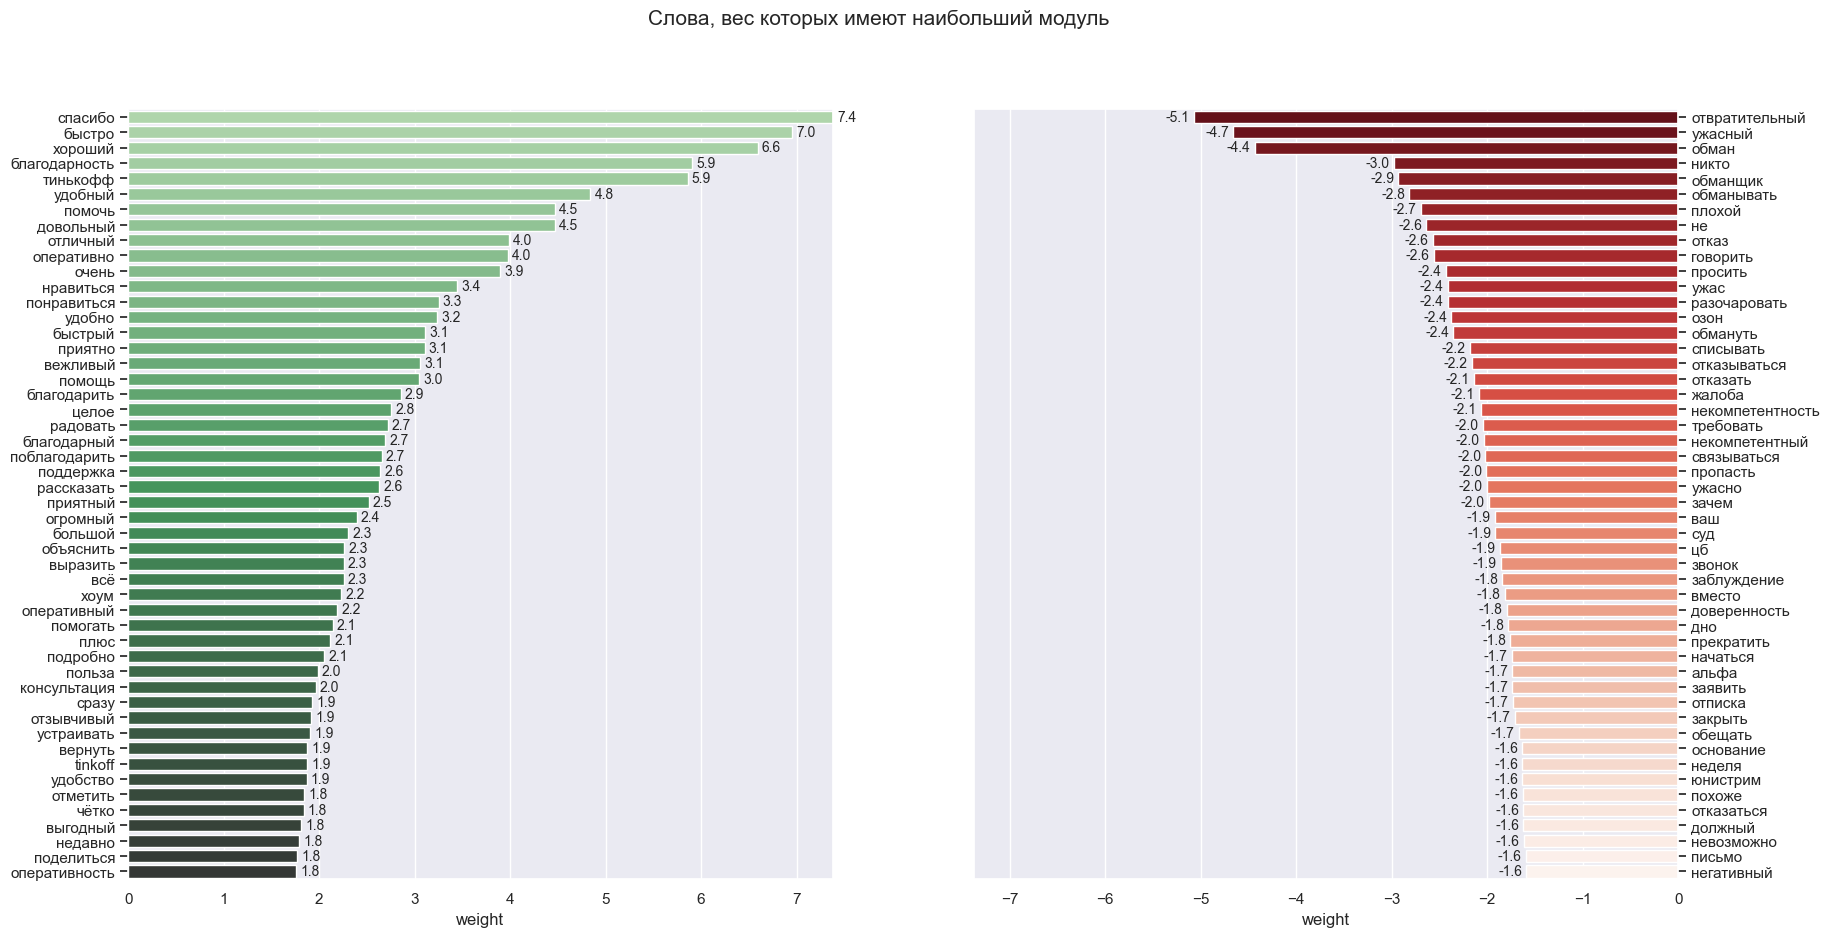

In [39]:
# Визуализируем слова, которые сильно влияют на окраску отзыва

pos = weights[weights['weight']>0].sort_values('weight', ascending=False)[:50]
neg = weights[weights['weight']<0].sort_values('weight', ascending=True)[:50]

f, axs = plt.subplots(figsize=(20,10), ncols=2)
f.suptitle('Cлова, вес которых имеют наибольший модуль', fontsize=15) # Добавляем название чарта

axs[0] = sns.barplot(data=pos, x="weight", y='lemma', ax=axs[0], palette='Greens_d')
axs[0].bar_label(axs[0].containers[0], fontsize=10, padding=3, fmt='%.1f') # Добавляем подписи к столбцам
axs[0].yaxis.tick_left()
axs[0].set(ylabel=None);  # Переименовываем оси
axs[0].set(xlim=(0, max(weights['abs_weight'])))

axs[1] = sns.barplot(data=neg, x="weight", y='lemma', ax=axs[1], palette='Reds_r')
axs[1].bar_label(axs[1].containers[0], fontsize=10, padding=3, fmt='%.1f') # Добавляем подписи к столбцам
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set(xlim=(-max(weights['abs_weight']),0)) # Делаем диапазон (по модулю) оси Х фиксированным
axs[1].set(ylabel=None);  # Переименовываем оси

В числе слов с наибольшим весом было обнаружено "Тинькофф" (и "Tinkoff"), а также "Хоум" (очевидно из "Хоум Кредит Банк"). Это наводит на мысль, что этап чистки данных также должен включать удаление названий банков.

## Пробуем Catboost

In [ ]:
# !pip install catboost
# !pip install ipywidgets

In [56]:
# Делим датасет на обучающую и тестовую выборки. 
# На вход будет подаваться лемматизированные заголовки+отзывы и длины отзывов

X = df[['bow_title', 'bow_body']]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

In [58]:
from catboost import Pool

text_features = ['bow_title', 'bow_body']

train_pool = Pool(
    X_train, y_train, 
    text_features=text_features,
)

test_pool = Pool(
    X_test, y_test, 
    text_features=text_features,
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

Train dataset shape: (69551, 2)



In [71]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    eval_metric='F1',
)

# Указываем диапазоны гиперпараметров для RandomSearch
param_dist = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 6]
}

model.randomized_search(param_dist, X=train_pool)

0:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 12.9ms	remaining: 1.28s
1:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 25ms	remaining: 1.23s
2:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 36.7ms	remaining: 1.19s
3:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 48.7ms	remaining: 1.17s
4:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 60.8ms	remaining: 1.16s
5:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 73ms	remaining: 1.14s
6:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 84.8ms	remaining: 1.13s
7:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 97.1ms	remaining: 1.12s
8:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 109ms	remaining: 1.1s
9:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 121ms	remaining: 1.09s
10:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 134ms	remaining: 1.08s
11:	learn: 0.8727829	test: 0.8735576	best: 0.87355

1:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 26.7ms	remaining: 1.31s
2:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 39.6ms	remaining: 1.28s
3:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 53.7ms	remaining: 1.29s
4:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 68.1ms	remaining: 1.29s
5:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 81.1ms	remaining: 1.27s
6:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 94.7ms	remaining: 1.26s
7:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 108ms	remaining: 1.24s
8:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 121ms	remaining: 1.22s
9:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 133ms	remaining: 1.2s
10:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 146ms	remaining: 1.18s
11:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 159ms	remaining: 1.17s
12:	learn: 0.8727829	test: 0.8735576	best: 0.87

6:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 91ms	remaining: 2.51s
7:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 104ms	remaining: 2.49s
8:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 117ms	remaining: 2.49s
9:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 131ms	remaining: 2.48s
10:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 144ms	remaining: 2.47s
11:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 157ms	remaining: 2.45s
12:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 169ms	remaining: 2.43s
13:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 181ms	remaining: 2.41s
14:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 194ms	remaining: 2.39s
15:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 207ms	remaining: 2.38s
16:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 220ms	remaining: 2.36s
17:	learn: 0.8727829	test: 0.8735576	best: 0.873

104:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.36s	remaining: 1.23s
105:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.37s	remaining: 1.22s
106:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.38s	remaining: 1.2s
107:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.4s	remaining: 1.19s
108:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.41s	remaining: 1.18s
109:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.42s	remaining: 1.16s
110:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.44s	remaining: 1.15s
111:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.45s	remaining: 1.14s
112:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.46s	remaining: 1.13s
113:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.48s	remaining: 1.11s
114:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.49s	remaining: 1.1s
115:	learn: 0.8727829	test: 0.87355

2:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 40.2ms	remaining: 2.64s
3:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 53.7ms	remaining: 2.63s
4:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 67.9ms	remaining: 2.65s
5:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 80.7ms	remaining: 2.61s
6:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 94.5ms	remaining: 2.61s
7:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 109ms	remaining: 2.61s
8:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 122ms	remaining: 2.59s
9:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 135ms	remaining: 2.57s
10:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 148ms	remaining: 2.54s
11:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 162ms	remaining: 2.53s
12:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 175ms	remaining: 2.51s
13:	learn: 0.8727829	test: 0.8735576	best: 0.8

115:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.33s	remaining: 960ms
116:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.34s	remaining: 949ms
117:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.35s	remaining: 937ms
118:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.36s	remaining: 926ms
119:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.37s	remaining: 914ms
120:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.38s	remaining: 903ms
121:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.39s	remaining: 891ms
122:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.4s	remaining: 879ms
123:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.41s	remaining: 867ms
124:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.43s	remaining: 856ms
125:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.44s	remaining: 844ms
126:	learn: 0.8727829	test: 0.873

12:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 151ms	remaining: 1.01s
13:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 163ms	remaining: 1s
14:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 175ms	remaining: 993ms
15:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 187ms	remaining: 983ms
16:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 199ms	remaining: 973ms
17:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 211ms	remaining: 960ms
18:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 223ms	remaining: 950ms
19:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 235ms	remaining: 938ms
20:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 247ms	remaining: 929ms
21:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 259ms	remaining: 919ms
22:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 271ms	remaining: 906ms
23:	learn: 0.8727829	test: 0.8735576	best: 0.8

23:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 271ms	remaining: 860ms
24:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 284ms	remaining: 851ms
25:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 295ms	remaining: 839ms
26:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 306ms	remaining: 827ms
27:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 317ms	remaining: 816ms
28:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 328ms	remaining: 804ms
29:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 339ms	remaining: 792ms
30:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 350ms	remaining: 780ms
31:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 361ms	remaining: 767ms
32:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 372ms	remaining: 755ms
33:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 383ms	remaining: 743ms
34:	learn: 0.8727829	test: 0.8735576	best: 

20:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 242ms	remaining: 2.06s
21:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 254ms	remaining: 2.06s
22:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 265ms	remaining: 2.04s
23:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 277ms	remaining: 2.03s
24:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 288ms	remaining: 2.02s
25:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 300ms	remaining: 2s
26:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 311ms	remaining: 1.99s
27:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 322ms	remaining: 1.98s
28:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 334ms	remaining: 1.97s
29:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 345ms	remaining: 1.96s
30:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 357ms	remaining: 1.94s
31:	learn: 0.8727829	test: 0.8735576	best: 0.8

130:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.53s	remaining: 804ms
131:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.54s	remaining: 793ms
132:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.55s	remaining: 781ms
133:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.56s	remaining: 769ms
134:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.57s	remaining: 757ms
135:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.58s	remaining: 746ms
136:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.6s	remaining: 735ms
137:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.61s	remaining: 723ms
138:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.62s	remaining: 711ms
139:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.63s	remaining: 699ms
140:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.64s	remaining: 687ms
141:	learn: 0.8727829	test: 0.873

36:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 439ms	remaining: 1.93s
37:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 452ms	remaining: 1.92s
38:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 463ms	remaining: 1.91s
39:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 476ms	remaining: 1.9s
40:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 487ms	remaining: 1.89s
41:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 499ms	remaining: 1.88s
42:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 512ms	remaining: 1.87s
43:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 523ms	remaining: 1.85s
44:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 534ms	remaining: 1.84s
45:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 546ms	remaining: 1.83s
46:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 557ms	remaining: 1.81s
47:	learn: 0.8727829	test: 0.8735576	best: 0

132:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.48s	remaining: 743ms
133:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.49s	remaining: 732ms
134:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.5s	remaining: 721ms
135:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.51s	remaining: 709ms
136:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.52s	remaining: 698ms
137:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.53s	remaining: 687ms
138:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.54s	remaining: 676ms
139:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.55s	remaining: 664ms
140:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.56s	remaining: 653ms
141:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.57s	remaining: 641ms
142:	learn: 0.8727829	test: 0.8735576	best: 0.8735576 (0)	total: 1.58s	remaining: 630ms
143:	learn: 0.8727829	test: 0.873

25:	learn: 0.9725087	test: 0.9737330	best: 0.9739277 (20)	total: 1.25s	remaining: 3.55s
26:	learn: 0.9727493	test: 0.9739374	best: 0.9739374 (26)	total: 1.3s	remaining: 3.51s
27:	learn: 0.9728077	test: 0.9740813	best: 0.9740813 (27)	total: 1.34s	remaining: 3.46s
28:	learn: 0.9731975	test: 0.9744266	best: 0.9744266 (28)	total: 1.4s	remaining: 3.42s
29:	learn: 0.9733423	test: 0.9745720	best: 0.9745720 (29)	total: 1.45s	remaining: 3.37s
30:	learn: 0.9733408	test: 0.9744569	best: 0.9745720 (29)	total: 1.49s	remaining: 3.33s
31:	learn: 0.9733696	test: 0.9744856	best: 0.9745720 (29)	total: 1.54s	remaining: 3.28s
32:	learn: 0.9733552	test: 0.9744569	best: 0.9745720 (29)	total: 1.59s	remaining: 3.23s
33:	learn: 0.9733552	test: 0.9744569	best: 0.9745720 (29)	total: 1.64s	remaining: 3.18s
34:	learn: 0.9733408	test: 0.9744569	best: 0.9745720 (29)	total: 1.69s	remaining: 3.14s
35:	learn: 0.9733696	test: 0.9744856	best: 0.9745720 (29)	total: 1.75s	remaining: 3.12s
36:	learn: 0.9734280	test: 0.97454

19:	learn: 0.9722445	test: 0.9736827	best: 0.9737131 (10)	total: 1s	remaining: 4s
20:	learn: 0.9723659	test: 0.9737663	best: 0.9737663 (20)	total: 1.07s	remaining: 4.04s
21:	learn: 0.9722316	test: 0.9736842	best: 0.9737663 (20)	total: 1.16s	remaining: 4.11s
22:	learn: 0.9723788	test: 0.9738211	best: 0.9738211 (22)	total: 1.22s	remaining: 4.07s
23:	learn: 0.9723659	test: 0.9737663	best: 0.9738211 (22)	total: 1.27s	remaining: 4.02s
24:	learn: 0.9723925	test: 0.9738211	best: 0.9738211 (22)	total: 1.32s	remaining: 3.95s
25:	learn: 0.9724502	test: 0.9738788	best: 0.9738788 (25)	total: 1.37s	remaining: 3.9s
26:	learn: 0.9725452	test: 0.9739610	best: 0.9739610 (26)	total: 1.43s	remaining: 3.86s
27:	learn: 0.9726037	test: 0.9741067	best: 0.9741067 (27)	total: 1.49s	remaining: 3.82s
28:	learn: 0.9726158	test: 0.9741067	best: 0.9741067 (27)	total: 1.54s	remaining: 3.78s
29:	learn: 0.9725893	test: 0.9741067	best: 0.9741067 (27)	total: 1.6s	remaining: 3.73s
30:	learn: 0.9726037	test: 0.9741067	bes

12:	learn: 0.9723942	test: 0.9730019	best: 0.9730583 (2)	total: 739ms	remaining: 4.95s
13:	learn: 0.9726095	test: 0.9732045	best: 0.9732045 (13)	total: 801ms	remaining: 4.92s
14:	learn: 0.9726095	test: 0.9732045	best: 0.9732045 (13)	total: 868ms	remaining: 4.92s
15:	learn: 0.9726239	test: 0.9732045	best: 0.9732045 (13)	total: 929ms	remaining: 4.88s
16:	learn: 0.9726239	test: 0.9732045	best: 0.9732045 (13)	total: 992ms	remaining: 4.84s
17:	learn: 0.9726239	test: 0.9732045	best: 0.9732045 (13)	total: 1.05s	remaining: 4.81s
18:	learn: 0.9727260	test: 0.9734463	best: 0.9734463 (18)	total: 1.12s	remaining: 4.76s
19:	learn: 0.9727260	test: 0.9734463	best: 0.9734463 (18)	total: 1.18s	remaining: 4.73s
20:	learn: 0.9727131	test: 0.9734189	best: 0.9734463 (18)	total: 1.24s	remaining: 4.67s
21:	learn: 0.9729069	test: 0.9737124	best: 0.9737124 (21)	total: 1.3s	remaining: 4.61s
22:	learn: 0.9727680	test: 0.9734503	best: 0.9737124 (21)	total: 1.36s	remaining: 4.56s
23:	learn: 0.9729084	test: 0.97377

{'params': {'depth': 3, 'iterations': 100, 'learning_rate': 0.01},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
   

In [75]:
# Метрики модели
cbc_pred = model.predict(test_pool)
print(classification_report(y_test, cbc_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      5161
           1       0.98      0.97      0.97     18023

    accuracy                           0.96     23184
   macro avg       0.93      0.95      0.94     23184
weighted avg       0.96      0.96      0.96     23184



In [77]:
f1_score(y_test, cbc_pred)

0.9742656324381843